In [1]:
import os
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
list_image = sorted(glob(os.getenv("HOME")+'/aiffel/coarse_to_fine/data/train/input/img/*.png'))
list_label = sorted(glob(os.getenv("HOME")+'/aiffel/coarse_to_fine/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

IMAGE_SHAPE = (80, 120)
data_root = os.getenv("HOME")+'/aiffel/coarse_to_fine/data/train/input'
label_root = os.getenv("HOME")+'/aiffel/coarse_to_fine/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=10)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=10)

23710 23710
Found 23710 images belonging to 1 classes.
Found 23710 images belonging to 1 classes.


In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.        0.        1.        1.        0.5158174 0.49375  ]
(80, 120, 3) [0.         0.         1.         1.         0.35416666 0.375     ]


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


In [5]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()


(10, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [6]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [7]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [8]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 20160 32 630 -> 데이터를 batch_size 의 배수로 준비해 주세요.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=50,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23710 10 2371
Epoch 1/50


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


2371/2371 [==============================] - 23s 10ms/step - loss: 0.0177 - mae: 0.0629
Epoch 2/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0140 - mae: 0.0544
Epoch 3/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0136 - mae: 0.0533
Epoch 4/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0131 - mae: 0.0523
Epoch 5/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0130 - mae: 0.0520
Epoch 6/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0128 - mae: 0.0515
Epoch 7/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0127 - mae: 0.0513
Epoch 8/50
2371/2371 [==============================] - 23s 10ms/step - loss: 0.0126 - mae: 0.0512
Epoch 9/50
2371/2371 [==============================] - 24s 10ms/step - loss: 0.0126 - mae: 0.0512
Epoch 10/50
2371/2371 [==============================] - 24s 10ms/step - loss: 0.0126 - mae: 0.0511
Epoch 11/50
2371/237

In [9]:
IMAGE_SHAPE = (80, 120)

val_data_root = os.getenv("HOME")+'/aiffel/coarse_to_fine/data/val/input'
val_label_root = os.getenv("HOME")+'/aiffel/coarse_to_fine/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2640 images belonging to 1 classes.
Found 2640 images belonging to 1 classes.


In [10]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012307049706578255 0.050666693598032


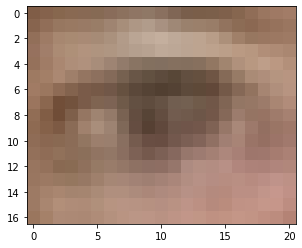

In [11]:
# img test
img = cv2.imread(os.getenv("HOME")+'/aiffel/coarse_to_fine/data/val/input/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[1.24777301e-07 3.34333549e-06]
  [1.19999985e+02 7.99994354e+01]
  [4.51798134e+01 2.86647778e+01]]]


[0. 0.]
[120.  80.]
[45. 29.]


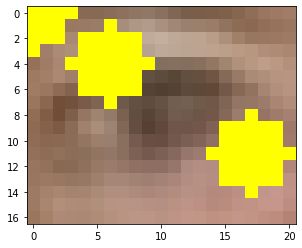

In [22]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.15).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()